<a href="https://colab.research.google.com/github/nemo0001/Python/blob/master/cardio_NN_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#getting the data from PC

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cardio_train.csv to cardio_train.csv
User uploaded file "cardio_train.csv" with length 2941524 bytes


###Importing Libraries

In [2]:
import numpy as np 
import pandas as pd 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from keras.optimizers import *
from keras.initializers import *
from keras.models import *
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# from keras.models import Sequential   # Type of neural network that will be used
# from keras.layers import Dense   # Dense layers for the neural network
# from keras.layers import Dropout   # Dropout in case we want to prevent overfitting, use after seeing results without
# from keras import optimizers   # Adam optimizer will be used

###Data Processing & Cleaning

In [3]:
data_raw=pd.read_csv("cardio_train.csv",sep=";")
data_raw.drop('id',axis=1,inplace=True)
data_raw.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:

data_raw.drop_duplicates(inplace=True)

In [5]:
x = data_raw.copy(deep=True)

#removing outliers
out_filter = ((x["ap_hi"]>250) | (x["ap_lo"]>200) )
x = x[~out_filter]
#Higher diastolic than systolic blood pressure is impossible, too. So let's remove these.
x.drop(x[x["ap_lo"] > x["ap_hi"]].index, inplace=True)
x.drop(x[x["ap_lo"] <= 30].index, inplace=True)
x.drop(x[x["ap_hi"] <= 40].index, inplace=True)
x.drop(x[x["ap_lo"] >= 200].index, inplace=True)
x.drop(x[x["ap_hi"] >= 250].index, inplace=True)

#Calculating BMI
def bmi_calc(w, h):
    return w/(h**2)
x["bmi"] = x["weight"]/ (x["height"]/100)**2

#Calculating Diff between systolic and diastolic :pulse pressure
x["BP_diff"]=x["ap_hi"]-x["ap_lo"]

x["gender"] = x["gender"] % 2

x.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,BP_diff
0,18393,0,168,62.0,110,80,1,1,0,0,1,0,21.967120,30
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,50
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,60
3,17623,0,169,82.0,150,100,1,1,0,0,1,1,28.710479,50
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,40


In [6]:
Y = x['cardio']
X = x.drop('cardio',axis=1)

#Dropping Irrelavant features
X.drop(["smoke"], axis=1,inplace=True)
X.drop(["alco"], axis=1,inplace=True)
X.drop(["height"], axis=1,inplace=True)

In [7]:

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
# s = StandardScaler()
# x_train = s.fit_transform(x_train)
# x_test = s.transform(x_test)

# Split train set in train and validation set:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

In [8]:
model = Sequential()

model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [9]:
from sklearn import metrics   # Allows us to view accuracy and other such values
from keras import optimizers   # Adam optimizer will be used

opt = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
nn = model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), batch_size=10)

Epoch 1/100
4394/4394 [==============================] - 5s 1ms/step - loss: 8.2916 - accuracy: 0.5151 - val_loss: 1.4594 - val_accuracy: 0.6097
Epoch 2/100
4394/4394 [==============================] - 6s 1ms/step - loss: 5.3635 - accuracy: 0.5308 - val_loss: 7.9014 - val_accuracy: 0.4913
Epoch 3/100
4394/4394 [==============================] - 6s 1ms/step - loss: 5.0369 - accuracy: 0.5350 - val_loss: 1.8270 - val_accuracy: 0.5180
Epoch 4/100
4394/4394 [==============================] - 5s 1ms/step - loss: 5.0624 - accuracy: 0.5358 - val_loss: 1.7038 - val_accuracy: 0.6147
Epoch 5/100
4394/4394 [==============================] - 5s 1ms/step - loss: 4.7015 - accuracy: 0.5392 - val_loss: 1.0299 - val_accuracy: 0.6423
Epoch 6/100
4394/4394 [==============================] - 5s 1ms/step - loss: 4.6282 - accuracy: 0.5430 - val_loss: 1.9031 - val_accuracy: 0.5204
Epoch 7/100
4394/4394 [==============================] - 5s 1ms/step - loss: 4.7415 - accuracy: 0.5452 - val_loss: 4.6247 - val_ac

430/430 [==============================] - 0s 903us/step - loss: 0.5843 - accuracy: 0.6993
Testing Acc: 0.6992716789245605
Confusion Matrix: 
 [[3972 2986]
 [1143 5629]]
AUC-score: 0.7885341858763754


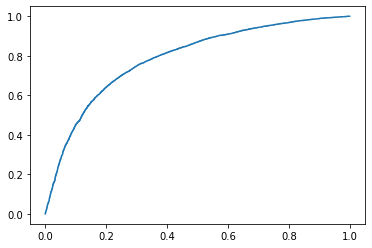

In [10]:
# Testing
test_score = model.evaluate(x_test, y_test)
print("Testing Acc:", test_score[1])

y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred.round())
print("Confusion Matrix:", "\n", cm)

tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
print("AUC-score:", auc_score)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(tpr, fpr)
plt.show()